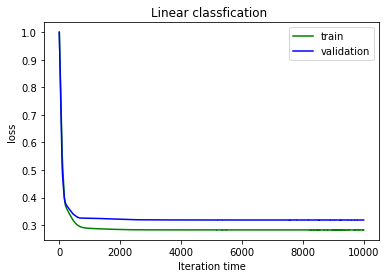

0.7318840579710145


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

#读取数据 X和y用以记录 总输入和总输出
X,y=load_svmlight_file("G:/australian_scale")

#为输入后加上一列1,并记录总输入的样本数和特征数
X = X.toarray()
row,col=X.shape
X=np.column_stack((X,np.ones((row,1))))

#切分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#接下来先拿X_train和y_train开刀
row_train,col_train=X_train.shape
y_train=y_train.reshape(row_train,1)

row_test,col_test=X_test.shape
y_test=y_test.reshape(row_test,1)

#初始化参数 选择全零初始化
W=np.zeros((col+1,1))

#确定学习率和训练次数
n=0.00001
count=0
max_count=10000


#用数组记录loss
loss_train=np.zeros(max_count)
loss_validation=np.zeros(max_count)

while(count<max_count):
    i=0
    j=0
    G_hinge=np.zeros((col+1,1))
    loss_hinge_train=0
    loss_hinge_validation=0
    while(i<row_train):
        if(y_train[i].dot(W.T.dot(X_train[i]))<1):
            y_train_cell=y_train[i].reshape(1,1)
            X_train_cell=X_train[i].reshape(15,1)
            G_hinge+=-X_train_cell.dot(y_train_cell)
            loss_hinge_train+=1-y_train[i].dot(W.T.dot(X_train[i]))
            i+=1
        else:
            i+=1
    while(j<row_test):
        if(y_test[j].dot(W.T.dot(X_test[j]))<1):
            loss_hinge_validation+=1-y_test[j].dot(W.T.dot(X_test[j]))
        j+=1
        
    G=W+G_hinge
    loss_train[count]=loss_hinge_train
    loss_validation[count]=loss_hinge_validation
    W=W-n*G
    count+=1
    
count=0
while(count<max_count):
    loss_train[count]=loss_train[count]/row_train
    loss_validation[count]=loss_validation[count]/row_test
    count+=1

#绘图
x=range(max_count)
y_t = [loss_train[count] for count in x]
y_v=[loss_validation[count] for count in x]

plt.plot(x, y_t,'g-', label='train')  
plt.plot(x,y_v,'b-', label='validation')
plt.legend()

plt.xlabel('Iteration time')
plt.ylabel('loss')
plt.title('Linear classfication ')
plt.show()

right=0
j=0
while(j<row_test):
    if(W.T.dot(X_test[j])>=1):
        if(y_test[j][0]==1.0):
            right+=1
    if(W.T.dot(X_test[j])<=-1.0):
        if(y_test[j][0]==-1.0):
            right+=1
    j+=1
print(right/row_test)


In [27]:
y_test[0][0]


1.0